In [1]:

!pip install gdown timm

import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import timm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:
# Download and extract dataset
file_id = '1jsMUDlvsXWQu2BansJz73mAErVyNg_g7'
destination = '/content/shared_file.zip'
gdown.download(id=file_id, output=destination, quiet=False)

# Check if the file is indeed a ZIP file
zip_path = '/content/shared_file.zip'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("ZIP file opened successfully.")
        zip_ref.extractall('/content')
    print("Extraction complete.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Downloading...
From (original): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7
From (redirected): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7&confirm=t&uuid=1ab83493-9ba1-4167-aaab-c8c22284ef64
To: /content/shared_file.zip
100%|██████████| 1.46G/1.46G [00:28<00:00, 51.7MB/s]


ZIP file opened successfully.
Extraction complete.
Using device: cuda


In [3]:
# Global Attention Block (GAB) from CABNet
class GAB(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(GAB, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ConvNeXtWithGAB(nn.Module):
    def __init__(self, num_classes=1000):
        super(ConvNeXtWithGAB, self).__init__()
        self.model = timm.create_model("hf_hub:timm/convnext_tiny.fb_in22k", pretrained=True)

        # Add GAB after each stage
        self.gab1 = GAB(96)
        self.gab2 = GAB(192)
        self.gab3 = GAB(384)
        self.gab4 = GAB(768)

        # Replace the final classification layer
        self.model.head.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        x = self.model.stem(x)

        x = self.model.stages[0](x)
        x = self.gab1(x)

        x = self.model.stages[1](x)
        x = self.gab2(x)

        x = self.model.stages[2](x)
        x = self.gab3(x)

        x = self.model.stages[3](x)
        x = self.gab4(x)

        x = self.model.head(x)
        return x

In [4]:
# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return img, label_tensor

# Data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load data
data_dirs = {
    'T4_Ptrain': ["l0", "l1", "l2"],
    'T4_Ptest': ["l0", "l1", "l2"]
}
data_root = "/content/T4_Pdata"

# Function to load dataset
def load_data(phase, data_dirs, data_root):
    data = []
    for label, folder in enumerate(data_dirs[phase]):
        folder_path = os.path.join(data_root, phase, folder)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            data.append((image_path, label))
    return data

train_data = load_data('T4_Ptrain', data_dirs, data_root)
test_data = load_data('T4_Ptest', data_dirs, data_root)

# Split train data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=[label for _, label in train_data])

# Create datasets
train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(val_data, transform=test_val_transform)
test_dataset = CustomDataset(test_data, transform=test_val_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Create the model
num_classes = len(data_dirs['T4_Ptrain'])
model = ConvNeXtWithGAB(num_classes=num_classes)


# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Move model to GPU
model.to(device)

# Define optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=1e-6)

# Define loss function with class weights
class_counts = np.bincount([label for _, label in train_data])
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [5]:
# Train the model
num_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar.set_postfix({'Loss': train_loss / total, 'Accuracy': 100 * correct / total})

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    scheduler.step(val_loss)

# Save the trained model
torch.save(model.state_dict(), '/content/convnext_gab_model.pth')

Epoch 1/100, Train Loss: 0.8252, Train Accuracy: 57.70%, Val Loss: 0.7436, Val Accuracy: 58.44%


Epoch 2/100, Train Loss: 0.6768, Train Accuracy: 66.39%, Val Loss: 0.7129, Val Accuracy: 67.83%


Epoch 3/100, Train Loss: 0.5776, Train Accuracy: 73.44%, Val Loss: 0.5902, Val Accuracy: 67.83%


Epoch 4/100, Train Loss: 0.5415, Train Accuracy: 72.93%, Val Loss: 0.4754, Val Accuracy: 75.96%


Epoch 5/100, Train Loss: 0.4312, Train Accuracy: 80.30%, Val Loss: 0.3986, Val Accuracy: 83.76%


Epoch 6/100, Train Loss: 0.3829, Train Accuracy: 83.01%, Val Loss: 0.4219, Val Accuracy: 83.12%


Epoch 7/100, Train Loss: 0.3077, Train Accuracy: 85.53%, Val Loss: 0.3528, Val Accuracy: 82.32%


Epoch 8/100, Train Loss: 0.2256, Train Accuracy: 89.75%, Val Loss: 0.4538, Val Accuracy: 85.51%


Epoch 9/100, Train Loss: 0.2158, Train Accuracy: 90.71%, Val Loss: 0.3764, Val Accuracy: 83.92%


Epoch 10/100, Train Loss: 0.1665, Train Accuracy: 92.34%, Val Loss: 0.3281, Val Accuracy: 87.10%


Epoch 11/100, Train Loss: 0.1340, Train Accuracy: 94.38%, Val Loss: 0.2706, Val Accuracy: 89.81%


Epoch 12/100, Train Loss: 0.1338, Train Accuracy: 94.34%, Val Loss: 0.3185, Val Accuracy: 87.26%


Epoch 13/100, Train Loss: 0.1084, Train Accuracy: 95.33%, Val Loss: 0.2787, Val Accuracy: 89.97%


Epoch 14/100, Train Loss: 0.0977, Train Accuracy: 96.13%, Val Loss: 0.3823, Val Accuracy: 89.01%


Epoch 15/100, Train Loss: 0.0878, Train Accuracy: 96.49%, Val Loss: 0.2748, Val Accuracy: 90.92%


Epoch 16/100, Train Loss: 0.0522, Train Accuracy: 97.53%, Val Loss: 0.3843, Val Accuracy: 91.24%


Epoch 17/100, Train Loss: 0.0891, Train Accuracy: 96.41%, Val Loss: 0.3376, Val Accuracy: 88.22%


Epoch 18/100, Train Loss: 0.0846, Train Accuracy: 96.13%, Val Loss: 0.3274, Val Accuracy: 91.40%


Epoch 19/100, Train Loss: 0.0697, Train Accuracy: 96.97%, Val Loss: 0.3166, Val Accuracy: 92.83%


Epoch 20/100, Train Loss: 0.0428, Train Accuracy: 98.21%, Val Loss: 0.3660, Val Accuracy: 89.97%


Epoch 21/100, Train Loss: 0.0285, Train Accuracy: 98.84%, Val Loss: 0.3354, Val Accuracy: 90.92%


Epoch 22/100, Train Loss: 0.0324, Train Accuracy: 98.72%, Val Loss: 0.4297, Val Accuracy: 88.54%


Epoch 23/100, Train Loss: 0.0266, Train Accuracy: 99.04%, Val Loss: 0.3208, Val Accuracy: 91.88%


Epoch 24/100, Train Loss: 0.0116, Train Accuracy: 99.56%, Val Loss: 0.3220, Val Accuracy: 92.52%


Epoch 25/100, Train Loss: 0.0095, Train Accuracy: 99.68%, Val Loss: 0.3263, Val Accuracy: 92.99%


Epoch 26/100, Train Loss: 0.0087, Train Accuracy: 99.76%, Val Loss: 0.3345, Val Accuracy: 92.36%


Epoch 27/100, Train Loss: 0.0087, Train Accuracy: 99.84%, Val Loss: 0.3357, Val Accuracy: 92.36%


Epoch 28/100, Train Loss: 0.0067, Train Accuracy: 99.76%, Val Loss: 0.3253, Val Accuracy: 92.52%


Epoch 29/100, Train Loss: 0.0068, Train Accuracy: 99.76%, Val Loss: 0.3332, Val Accuracy: 92.52%


Epoch 30/100, Train Loss: 0.0064, Train Accuracy: 99.80%, Val Loss: 0.3318, Val Accuracy: 92.52%


Epoch 31/100, Train Loss: 0.0048, Train Accuracy: 99.88%, Val Loss: 0.3341, Val Accuracy: 92.36%


Epoch 32/100, Train Loss: 0.0055, Train Accuracy: 99.84%, Val Loss: 0.3425, Val Accuracy: 92.36%


Epoch 33/100, Train Loss: 0.0064, Train Accuracy: 99.76%, Val Loss: 0.3356, Val Accuracy: 92.36%


Epoch 34/100, Train Loss: 0.0047, Train Accuracy: 99.92%, Val Loss: 0.3353, Val Accuracy: 92.20%


Epoch 35/100, Train Loss: 0.0053, Train Accuracy: 99.76%, Val Loss: 0.3334, Val Accuracy: 92.36%


Epoch 36/100, Train Loss: 0.0043, Train Accuracy: 99.92%, Val Loss: 0.3328, Val Accuracy: 92.20%


Epoch 37/100, Train Loss: 0.0040, Train Accuracy: 99.84%, Val Loss: 0.3331, Val Accuracy: 92.20%


Epoch 38/100, Train Loss: 0.0053, Train Accuracy: 99.92%, Val Loss: 0.3326, Val Accuracy: 92.36%


Epoch 39/100, Train Loss: 0.0058, Train Accuracy: 99.84%, Val Loss: 0.3334, Val Accuracy: 92.36%


Epoch 40/100, Train Loss: 0.0045, Train Accuracy: 99.84%, Val Loss: 0.3330, Val Accuracy: 92.36%


Epoch 41/100, Train Loss: 0.0060, Train Accuracy: 99.72%, Val Loss: 0.3333, Val Accuracy: 92.36%


Epoch 42/100, Train Loss: 0.0039, Train Accuracy: 99.88%, Val Loss: 0.3345, Val Accuracy: 92.52%


Epoch 43/100, Train Loss: 0.0056, Train Accuracy: 99.88%, Val Loss: 0.3331, Val Accuracy: 92.52%


Epoch 44/100, Train Loss: 0.0083, Train Accuracy: 99.72%, Val Loss: 0.3307, Val Accuracy: 92.20%


Epoch 45/100, Train Loss: 0.0047, Train Accuracy: 99.80%, Val Loss: 0.3311, Val Accuracy: 92.20%


Epoch 46/100, Train Loss: 0.0040, Train Accuracy: 99.92%, Val Loss: 0.3297, Val Accuracy: 92.20%


Epoch 47/100, Train Loss: 0.0045, Train Accuracy: 99.88%, Val Loss: 0.3307, Val Accuracy: 92.36%


Epoch 48/100, Train Loss: 0.0034, Train Accuracy: 99.88%, Val Loss: 0.3320, Val Accuracy: 92.36%


Epoch 49/100, Train Loss: 0.0044, Train Accuracy: 99.84%, Val Loss: 0.3316, Val Accuracy: 92.36%


Epoch 50/100, Train Loss: 0.0050, Train Accuracy: 99.80%, Val Loss: 0.3316, Val Accuracy: 92.36%


Epoch 51/100, Train Loss: 0.0035, Train Accuracy: 99.92%, Val Loss: 0.3331, Val Accuracy: 92.36%


Epoch 52/100, Train Loss: 0.0062, Train Accuracy: 99.68%, Val Loss: 0.3351, Val Accuracy: 92.52%


Epoch 53/100, Train Loss: 0.0039, Train Accuracy: 99.88%, Val Loss: 0.3369, Val Accuracy: 92.52%


Epoch 54/100, Train Loss: 0.0040, Train Accuracy: 99.96%, Val Loss: 0.3359, Val Accuracy: 92.52%


Epoch 55/100, Train Loss: 0.0041, Train Accuracy: 99.84%, Val Loss: 0.3381, Val Accuracy: 92.52%


Epoch 56/100, Train Loss: 0.0040, Train Accuracy: 99.92%, Val Loss: 0.3356, Val Accuracy: 92.52%


Epoch 57/100, Train Loss: 0.0031, Train Accuracy: 99.96%, Val Loss: 0.3365, Val Accuracy: 92.36%


Epoch 58/100, Train Loss: 0.0037, Train Accuracy: 99.92%, Val Loss: 0.3358, Val Accuracy: 92.36%


Epoch 59/100, Train Loss: 0.0028, Train Accuracy: 99.96%, Val Loss: 0.3371, Val Accuracy: 92.36%


Epoch 60/100, Train Loss: 0.0049, Train Accuracy: 99.76%, Val Loss: 0.3340, Val Accuracy: 92.20%


Epoch 61/100, Train Loss: 0.0060, Train Accuracy: 99.80%, Val Loss: 0.3347, Val Accuracy: 92.20%


Epoch 62/100, Train Loss: 0.0034, Train Accuracy: 99.96%, Val Loss: 0.3365, Val Accuracy: 92.20%


Epoch 63/100, Train Loss: 0.0040, Train Accuracy: 99.88%, Val Loss: 0.3390, Val Accuracy: 92.52%


Epoch 64/100, Train Loss: 0.0025, Train Accuracy: 100.00%, Val Loss: 0.3405, Val Accuracy: 92.52%


Epoch 65/100, Train Loss: 0.0038, Train Accuracy: 99.96%, Val Loss: 0.3412, Val Accuracy: 92.52%


Epoch 66/100, Train Loss: 0.0038, Train Accuracy: 99.88%, Val Loss: 0.3389, Val Accuracy: 92.52%


Epoch 67/100, Train Loss: 0.0035, Train Accuracy: 99.96%, Val Loss: 0.3366, Val Accuracy: 92.52%


Epoch 68/100, Train Loss: 0.0031, Train Accuracy: 99.92%, Val Loss: 0.3367, Val Accuracy: 92.52%


Epoch 69/100, Train Loss: 0.0032, Train Accuracy: 99.92%, Val Loss: 0.3361, Val Accuracy: 92.36%


Epoch 70/100, Train Loss: 0.0031, Train Accuracy: 99.96%, Val Loss: 0.3371, Val Accuracy: 92.68%


Epoch 71/100, Train Loss: 0.0043, Train Accuracy: 99.76%, Val Loss: 0.3370, Val Accuracy: 92.52%


Epoch 72/100, Train Loss: 0.0029, Train Accuracy: 99.92%, Val Loss: 0.3418, Val Accuracy: 92.52%


Epoch 73/100, Train Loss: 0.0031, Train Accuracy: 99.92%, Val Loss: 0.3403, Val Accuracy: 92.36%


Epoch 74/100, Train Loss: 0.0032, Train Accuracy: 99.96%, Val Loss: 0.3434, Val Accuracy: 92.36%


Epoch 75/100, Train Loss: 0.0040, Train Accuracy: 99.88%, Val Loss: 0.3395, Val Accuracy: 92.36%


Epoch 76/100, Train Loss: 0.0029, Train Accuracy: 100.00%, Val Loss: 0.3437, Val Accuracy: 92.52%


Epoch 77/100, Train Loss: 0.0030, Train Accuracy: 99.92%, Val Loss: 0.3446, Val Accuracy: 92.52%


Epoch 78/100, Train Loss: 0.0024, Train Accuracy: 100.00%, Val Loss: 0.3464, Val Accuracy: 92.36%


Epoch 79/100, Train Loss: 0.0030, Train Accuracy: 99.92%, Val Loss: 0.3456, Val Accuracy: 92.52%


Epoch 80/100, Train Loss: 0.0045, Train Accuracy: 99.92%, Val Loss: 0.3427, Val Accuracy: 92.20%


Epoch 81/100, Train Loss: 0.0026, Train Accuracy: 99.96%, Val Loss: 0.3468, Val Accuracy: 92.36%


Epoch 82/100, Train Loss: 0.0033, Train Accuracy: 99.92%, Val Loss: 0.3494, Val Accuracy: 92.20%


Epoch 83/100, Train Loss: 0.0033, Train Accuracy: 99.88%, Val Loss: 0.3468, Val Accuracy: 92.20%


Epoch 84/100, Train Loss: 0.0029, Train Accuracy: 99.92%, Val Loss: 0.3469, Val Accuracy: 92.20%


Epoch 85/100, Train Loss: 0.0032, Train Accuracy: 99.92%, Val Loss: 0.3480, Val Accuracy: 92.20%


Epoch 86/100, Train Loss: 0.0026, Train Accuracy: 99.96%, Val Loss: 0.3518, Val Accuracy: 92.52%


Epoch 87/100, Train Loss: 0.0026, Train Accuracy: 99.96%, Val Loss: 0.3468, Val Accuracy: 92.20%


Epoch 88/100, Train Loss: 0.0024, Train Accuracy: 100.00%, Val Loss: 0.3485, Val Accuracy: 92.20%


Epoch 89/100, Train Loss: 0.0030, Train Accuracy: 99.96%, Val Loss: 0.3462, Val Accuracy: 92.20%


Epoch 90/100, Train Loss: 0.0020, Train Accuracy: 99.96%, Val Loss: 0.3480, Val Accuracy: 92.20%


Epoch 91/100, Train Loss: 0.0023, Train Accuracy: 99.88%, Val Loss: 0.3525, Val Accuracy: 92.36%


Epoch 92/100, Train Loss: 0.0030, Train Accuracy: 99.88%, Val Loss: 0.3541, Val Accuracy: 92.52%


Epoch 93/100, Train Loss: 0.0023, Train Accuracy: 99.96%, Val Loss: 0.3545, Val Accuracy: 92.36%


Epoch 94/100, Train Loss: 0.0028, Train Accuracy: 99.96%, Val Loss: 0.3529, Val Accuracy: 92.52%


Epoch 95/100, Train Loss: 0.0024, Train Accuracy: 99.92%, Val Loss: 0.3555, Val Accuracy: 92.52%


Epoch 96/100, Train Loss: 0.0031, Train Accuracy: 99.92%, Val Loss: 0.3574, Val Accuracy: 92.36%


Epoch 97/100, Train Loss: 0.0026, Train Accuracy: 99.96%, Val Loss: 0.3577, Val Accuracy: 92.36%


Epoch 98/100, Train Loss: 0.0028, Train Accuracy: 100.00%, Val Loss: 0.3532, Val Accuracy: 92.36%


Epoch 99/100, Train Loss: 0.0023, Train Accuracy: 99.92%, Val Loss: 0.3555, Val Accuracy: 92.20%


Epoch 100/100, Train Loss: 0.0023, Train Accuracy: 99.92%, Val Loss: 0.3598, Val Accuracy: 92.20%


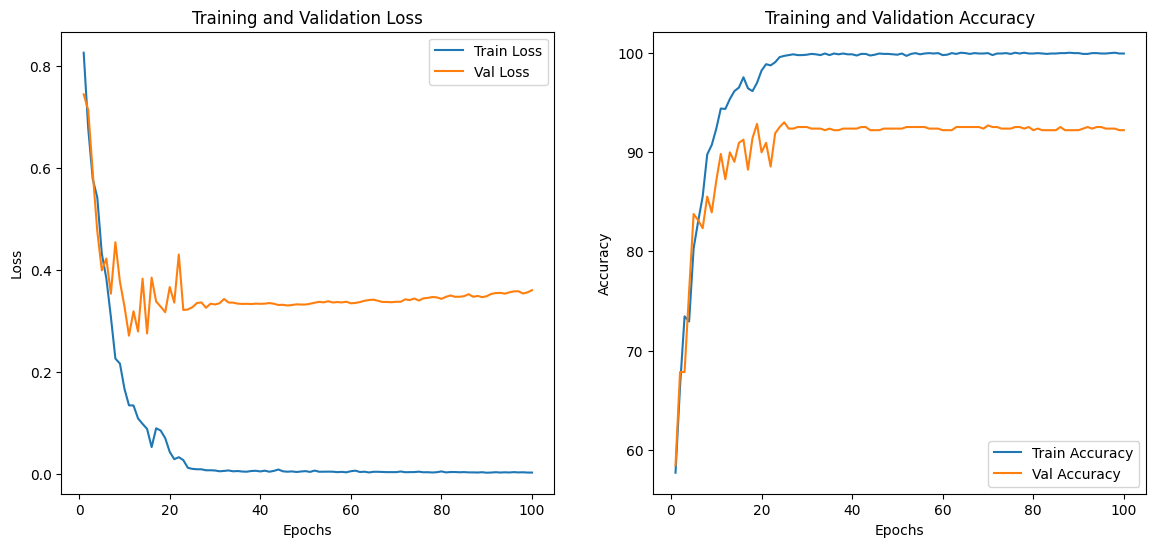

In [6]:

# Plotting training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [7]:

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted)
        true_labels.extend(labels)

# Generate classification report
true_labels = torch.tensor(true_labels).cpu().numpy()
predictions = torch.tensor(predictions).cpu().numpy()
report = classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)])
print(report)


Test Accuracy: 92.03%
              precision    recall  f1-score   support

     Class 0       0.91      0.86      0.89       118
     Class 1       0.93      0.95      0.94       187
     Class 2       0.92      0.93      0.92       322

    accuracy                           0.92       627
   macro avg       0.92      0.91      0.92       627
weighted avg       0.92      0.92      0.92       627



In [8]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import numpy as np

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)]))

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Calculate per-class metrics
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1_score = 2 * precision * recall / (precision + recall)

# Calculate macro-averaged metrics
macro_recall = np.mean(recall)
macro_precision = np.mean(precision)
macro_f1_score = np.mean(f1_score)
accuracy = np.sum(TP) / np.sum(cm)
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
custom_balanced_accuracy = np.mean((recall + specificity) / 2)

# Print class-wise metrics
print("\nClass-wise Metrics:")
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  Specificity: {specificity[i]:.3f}")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

# Print macro-averaged metrics
print("\nMacro-averaged Metrics:")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro F1-score: {macro_f1_score:.3f}")
print(f"Accuracy (ACC): {accuracy:.3f}")
print(f"Balanced Accuracy (BAC): {balanced_accuracy:.3f}")
print(f"Custom Balanced Accuracy (BCC): {custom_balanced_accuracy:.3f}")


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      0.86      0.89       118
     Class 1       0.93      0.95      0.94       187
     Class 2       0.92      0.93      0.92       322

    accuracy                           0.92       627
   macro avg       0.92      0.91      0.92       627
weighted avg       0.92      0.92      0.92       627

Confusion Matrix:
[[102   0  16]
 [  0 177  10]
 [ 10  14 298]]

Class-wise Metrics:
Class 0:
  TP: 102
  TN: 499
  FP: 10
  FN: 16
  Recall: 0.864
  Specificity: 0.980
  Precision: 0.911
  F1-score: 0.887
Class 1:
  TP: 177
  TN: 426
  FP: 14
  FN: 10
  Recall: 0.947
  Specificity: 0.968
  Precision: 0.927
  F1-score: 0.937
Class 2:
  TP: 298
  TN: 279
  FP: 26
  FN: 24
  Recall: 0.925
  Specificity: 0.915
  Precision: 0.920
  F1-score: 0.923

Macro-averaged Metrics:
Macro Recall: 0.912
Macro Precision: 0.919
Macro F1-score: 0.915
Accuracy (ACC): 0.920
Balanced Accuracy (BAC): 0.912
Custo